Welcome to the notebook demonstrating the entire pipeline for the report.

# ------ Imports and Setting Up the Notebook ------

In [0]:
%pip install PyPDF2==1.26.0 gensim==3.8.3 nltk==3.5 pyLDAvis==2.1.2 wordcloud==1.8.1 fuzzywuzzy==0.18.0 mlflow pandas sklearn 

Python interpreter will be restarted.
Collecting PyPDF2==1.26.0
 Using cached PyPDF2-1.26.0-py3-none-any.whl
Collecting gensim==3.8.3
 Using cached gensim-3.8.3-cp38-cp38-manylinux1_x86_64.whl (24.2 MB)
Collecting nltk==3.5
 Using cached nltk-3.5-py3-none-any.whl
Collecting pyLDAvis==2.1.2
 Using cached pyLDAvis-2.1.2-py2.py3-none-any.whl
Collecting wordcloud==1.8.1
 Using cached wordcloud-1.8.1-cp38-cp38-manylinux1_x86_64.whl (371 kB)
Collecting fuzzywuzzy==0.18.0
 Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl (18 kB)
Collecting mlflow
 Using cached mlflow-1.28.0-py3-none-any.whl (17.0 MB)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (1.2.4)
Collecting sklearn
 Using cached sklearn-0.0-py2.py3-none-any.whl
Requirement already satisfied: numpy>=1.11.3 in /databricks/python3/lib/python3.8/site-packages (from gensim==3.8.3) (1.20.1)
Requirement already satisfied: scipy>=0.18.1 in /databricks/python3/lib/python3.8/site-packages (from gensim==3.8.3) (1.6.2)
Collecting smart-open>=1.8.1
 Using cached smart_open-6.1.0-py3-none-any.whl (58 kB)
Requirement already satisfied: six>=1.5.0 in /databricks/python3/lib/python3.8/site-packages (from gensim==3.8.3) (1.15.0)
Requirement already satisfied: joblib in /databricks/python3/lib/python3.8/site-packages (from nltk==3.5) (1.0.1)
Collecting click
 Using cached click-8.1.3-py3-none-any.whl (96 kB)
Collecting regex
 Using cached regex-2022.8.17-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (768 kB)
Collecting tqdm
 Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
Collecting numexpr
 Using cached numexpr-2.8.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (381 kB)
Collecting pytest
 Using cached pytest-7.1.2-py3-none-any.whl (297 kB)
Requirement already satisfied: wheel>=0.23.0 in /databricks/python3/lib/python3.8/site-packages (from pyLDAvis==2.1.2) (0.36.2)
Requirement already satisfied: jinja2>=2.7.2 in /databricks/python3/lib/python3.8/site-packages (from pyLDAvis==2.1.2) (2.11.3)
Collecting funcy
 Using cached funcy-1.17-py2.py3-none-any.whl (33 kB)
Collecting future
 Using cached future-0.18.2-py3-none-any.whl
Requirement already satisfied: pillow in /databricks/python3/lib/python3.8/site-packages (from wordcloud==1.8.1) (8.2.0)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.8/site-packages (from wordcloud==1.8.1) (3.4.2)
Requirement already satisfied: pytz>=2017.3 in /databricks/python3/lib/python3.8/site-packages (from pandas) (2020.5)
Requirement already satisfied: python-dateutil>=2.7.3 in /databricks/python3/lib/python3.8/site-packages (from pandas) (2.8.1)
Requirement already satisfied: MarkupSafe>=0.23 in /databricks/python3/lib/python3.8/site-packages (from jinja2>=2.7.2->pyLDAvis==2.1.2) (2.0.1)
Collecting cloudpickle<3
 Using cached cloudpickle-2.1.0-py3-none-any.whl (25 kB)
Collecting databricks-cli<1,>=0.8.7
 Using cached databricks_cli-0.17.3-py3-none-any.whl
Collecting docker<6,>=4.0.0
 Using cached docker-5.0.3-py2.py3-none-any.whl (146 kB)
Collecting sqlparse<1,>=0.4.0
 Using cached sqlparse-0.4.2-py3-none-any.whl (42 kB)
Requirement already satisfied: entrypoints<1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Requirement already satisfied: requests<3,>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.25.1)
Requirement already satisfied: protobuf<5,>=3.12.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.2)
Collecting prometheus-flask-exporter<1
 Using cached prometheus_flask_exporter-0.20.3-py3-none-any.whl (18 kB)
Collecting pyyaml<7,>=5.1
 Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
Collecting alembic<2
 Using cached alembic-1.8.1-py3-none-any.whl (209 kB)
Collecting gitpython<4,>=2.1.0
 Using cached GitPython-3.1.27-py3-none-any.whl (181 kB)
Collecting sqlalchemy<2,>=1.4.0
 Using cached SQLAlchemy-1.4.4

In [0]:
# Extract the dataframe
import pandas as pd
from io import StringIO
import requests
from PyPDF2 import PdfFileReader
from io import BytesIO
import time

config = {
  "temp_dir"            : "/tmp/esg",
  "num_executors"       : "8",
  "csr_statements_table": "esg_scoring.csr_statements",
  "csr_statements_path" : "/FileStore/esg_scoring/data/csr/statements",
  "csr_topics_table"    : "esg_scoring.csr_topics",
  "csr_topics_path"     : "/FileStore/esg_scoring/data/csr/topics",
  "csr_scores_table"    : "esg_scoring.csr_scores",
  "csr_scores_path"     : "/FileStore/esg_scoring/data/csr/scores",
  "model_topic_name"    : "esg_topics",
  "model_scraper_name"  : "esg_scraper",
  "gdelt_raw_path"      : "/FileStore/esg_scoring/data/gdelt/raw",
  "gdelt_raw_min_date"  : "20210701000000",
  "gdelt_raw_max_date"  : "20210801000000",
  "gdelt_bronze_table"  : "esg_scoring.gdelt_bronze",
  "gdelt_bronze_fuzzy"  : "0.9",
  "gdelt_bronze_path"   : "/FileStore/esg_scoring/data/gdelt/bronze",
  "gdelt_silver_table"  : "esg_scoring.gdelt_silver",
  "gdelt_silver_path"   : "/FileStore/esg_scoring/data/gdelt/silver",
  "gdelt_gold_table"    : "esg_scoring.gdelt_gold",
  "gdelt_gold_path"     : "/FileStore/esg_scoring/data/gdelt/gold",
  "gdelt_threshold"     : "200",
  "gdelt_scores_table"  : "esg_scoring.gdelt_score",
  "gdelt_scores_path"   : "/FileStore/esg_scoring/data/gdelt/score",
}
 
# as-is, we simply retrieve dictionary key, but the reason we create a function
# is that user would be able to replace dictionary to application property file
# without impacting notebook code
def getParam(s):
  return config[s]


# ------ Content Extraction of PDF Reports -----

In [0]:
def extract_content(url):
    
    print(f"{url = }")

    try:
        response = requests.get(url, timeout=10)
    except:
        print("Url ", url, " failed to open")
        return ""
    else:
        try:
            open_pdf_file = BytesIO(response.content)
            pdf = PdfFileReader(open_pdf_file, strict=False)
            text = [pdf.getPage(i).extractText() for i in range(0, pdf.getNumPages())]
        except:
            print("No bueno")
            return ""
        else:
            return "\n".join(text)
        
# df['content'] = df['url'].apply(extract_content)

Use below if content has already been extracted and is stored in spark database to save time

In [0]:
df = sqlContext.sql("SELECT * FROM SASB2020ExtractedContent1")
df = df.toPandas()
df.drop(['_c0'], axis=1, inplace =True)
display(df.drop(['content'], axis=1))


Company_name,Industry,Sector,Country,Type_of_Document,Publication_Year,url
Jabil Inc,Electronic Manufacturing Services & Original Design Manufacturing,Technology & Communications,United States,Corporate Responsibility Reports,2020,https://www.jabil.com/dam/jcr:13e2fd90-9fa0-4103-9061-85efa1b725ba/jabil-ser-report-2019.pdf
JBG SMITH Properties,Real Estate,Infrastructure,United States,Corporate Responsibility Reports,2020,https://api-jbgsmith.reol.com/pdf?file_name=sustainability_report_2020.pdf
JLL - Jones Lang LaSalle Inc,Real Estate Services,Infrastructure,United States,Corporate Responsibility Reports,2020,https://www.jll.com.mx/content/dam/jll-com/documents/pdf/other/JLL-2019-Global-Sustainability-Report.pdf
Johnson Controls International,Electrical & Electronic Equipment,Resource Transformation,United States,Corporate Responsibility Reports,2020,https://www.johnsoncontrols.com/-/media/jci/corporate-sustainability/reporting-and-policies/gri/2019/johnson_controls_2020-sustainability-report.pdf?la=en&hash=63C4727C436616C656A41E32DC0613A2421F3657
JPMorgan Chase & Co,Investment Banking & Brokerage,Financials,United States,Corporate Responsibility Reports,2020,https://about.jpmorganchase.com/content/dam/jpmc/jpmorgan-chase-and-co/documents/jpmc-cr-sasb-index-2019.pdf
Juniper Networks Inc,Hardware,Technology & Communications,United States,Corporate Responsibility Reports,2020,https://www.juniper.net/assets/us/en/local/pdf/fact-sheets-backgrounder/3000071-en.pdf
KB Financial Group Inc,Commercial Banks,Financials,South Korea,Corporate Responsibility Reports,2020,https://www.kbfg.com/common/jsp/fileDownUtil.jsp?filepath=/Eng/about/sustainability/__attachFile/2019_KB_FInancial_Group_SR_Eng.pdf
KBC Group NV,Commercial Banks,Financials,Belgium,Corporate Responsibility Reports,2020,https://www.kbc.com/content/dam/kbccom/doc/sustainability-reponsability/PerfRep/2019/CSR_SR_2019_en.pdf
KBR Inc,Engineering & Construction Services,Infrastructure,United States,Corporate Responsibility Reports,2020,https://www.kbr.com/sites/default/files/2020-12/Sustainability_Report_2019_0.pdf
KDDI Corp,Telecommunication Services,Technology & Communications,Japan,Corporate Responsibility Reports,2020,https://www.kddi.com/extlib/files/english/corporate/csr/csr_report/2020/pdf/report2020_en-interactive.pdf


Read in additional airplane database (reports to supplement the ones here)

In [0]:
df_airlines = sqlContext.sql("SELECT * FROM airlines_csv")
df_airlines = df_airlines.toPandas().drop(["_c0","RPK_2017","RPK_2018","RPK_2019","2017_GHG_Scope_1__gCO2/RPK_", "2018_GHG_Scope_1__gCO2/RPK_", "2019_GHG_Scope_1__gCO2/RPK_", "OperatorType"], axis=1)
# df_airlines.groupby(["Company_name","Industry","Sector","Country","Type_of_Document","Publication_Year","url"])['content'].transform(lambda x : ' '.join(x))

company_names = df_airlines.Company_name.unique()
print(len(df))
df = df[~df["Company_name"].isin(company_names)]
print(len(df))



276
272

# ------ Stage 1: Text-Preprocessing ------

In [0]:
import nltk
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')
english_words = set(nltk.corpus.words.words())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data] Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Package punkt is already up-to-date!

In [0]:
import string
import re
num_texts = len(df)
def extract_statements(text):
  # remove non ASCII characters
  printable = set(string.printable)
  text = ''.join(filter(lambda x: x in printable, text))
  
  lines = []
  prev = ""
  for line in text.split('\n'):
    # aggregate consecutive lines where text may be broken down
    # only if next line starts with a space or previous does not end with a dot.
    if(line.startswith(' ') or not prev.endswith('.')):
        prev = prev + ' ' + line
    else:
        # new paragraph
        lines.append(prev)
        prev = line
        
  # don't forget left-over paragraph
  lines.append(prev)

  # clean paragraphs from extra space, unwanted characters, urls, etc.
  # best effort clean up, consider a more versatile cleaner
  sentences = []
  
  for line in lines:
      # removing header number
      line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
      # removing trailing spaces
      line = line.strip()
      # words may be split between lines, ensure we link them back together
      line = re.sub(r'\s?-\s?', '-', line)
      # remove space prior to punctuation
      line = re.sub(r'\s?([,:;\.])', r'\1', line)
      # ESG contains a lot of figures that are not relevant to grammatical structure
      line = re.sub(r'\d{5,}', r' ', line)
      # remove mentions of URLs
      line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
      # remove multiple spaces
      line = re.sub(r'\s+', ' ', line)
      # remove multiple dot
      line = re.sub(r'\.+', '.', line)
      
      # split paragraphs into well defined sentences using nltk
      for part in nltk.sent_tokenize(line):
        sentences.append(str(part).strip())

  return sentences   
# count = 0

df['statement'] = df['content'].apply(extract_statements)
df = df.explode('statement').reset_index(drop=True)


Merge airline dataset that has already been pre-processed with current dataset

In [0]:
df = pd.concat([df, df_airlines])
df = df[~df["Company_name"].isin(["Iberia", "Japan Airlines", "Lufthansa", "Singapore Air"])]

In [0]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

## Stopword removal

In [0]:
org_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annual', 'barclay',
  'esg', 'bank', 'report', 'csr',
  'disclosure', 'sustainable', 'sustainability'
  'corporate', 'responsibility',
  'million', 'billion',
]
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# add company names as stop words
organisations = set(df['Company_name'])
for organisation in organisations:
    for t in organisation.split(' '):
        org_stop_words.append(t)

# our list contains all english stop words + companies names + specific keywords
stop_words = STOPWORDS.union(org_stop_words)

In [0]:
df['statement'] = df['statement'].astype(str)

In [0]:
def lemmatize(text):
  results = []
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for token in simple_preprocess(text):
    if token not in stop_words and token in english_words: # Remove non-english_words
        new_token = (token)
        stem = stemmer.stem(lemmatizer.lemmatize(new_token))
        if (len(stem) > 3): # 3 letter words not included
          results.append(stem)
  return ' '.join(results)

df['lemma'] = df['statement'].apply(lemmatize)

## Add in TF-IDF to find additional stopwords and remove them

In [0]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# countvectorizer = CountVectorizer()
# tfidfvectorizer = TfidfVectorizer()
# corpus = df['lemma']
# X = tfidfvectorizer.fit_transform(corpus)
# TFIDFWeights = pd.DataFrame(X.sum(axis=0).T, index = tfidfvectorizer.get_feature_names(), columns = ["weight"]) 
# # TFIDFWeights[(TFIDFWeights["weight"]> 5) & (TFIDFWeights["weight"]<500)].hist(bins=1000)
# TFIDFWeights.reset_index(inplace=True)
# TFIDFWeights.sort_values(by="weight")

# new_stop_words = list(TFIDFWeights[TFIDFWeights["weight"]<0.05]["index"])
# len(new_stop_words)

In [0]:
# stop_words = stop_words.union(new_stop_words)
# len(stop_words)

Add new stopwords

In [0]:
# def lemmatize(text):
#   results = []
#   lemmatizer = WordNetLemmatizer()
#   stemmer = PorterStemmer()
#   for token in simple_preprocess(text):
#     if token not in stop_words and token in english_words: # Remove non-english_words
#         new_token = (token)
#         stem = stemmer.stem(lemmatizer.lemmatize(new_token))
#         if (len(stem) > 3): # 3 letter words not included
#           results.append(stem)
#   return ' '.join(results)
# df['lemma'] = df['statement'].apply(lemmatize)

## Filtering out words based on sentence length

### First explore the filter

In [0]:
df['count'] = df['lemma'].apply(len)
df['count_num_words'] = df['lemma'].apply(lambda x: len(x.split()))

Out[16]: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.

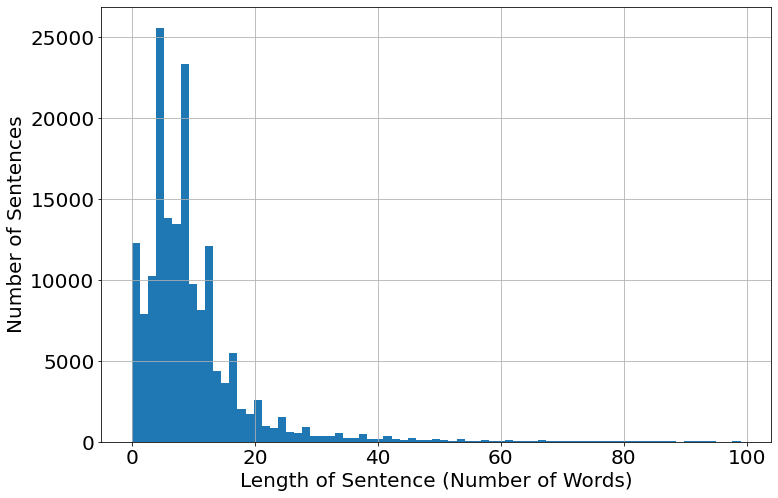

Text(0, 0.5, 'Number of Sentences')

In [0]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
fig, ax= plt.subplots(figsize = (12,8))

df[df['count_num_words']<100]['count_num_words'].hist(ax=ax, bins=75)
ax.set_xlabel("Length of Sentence (Number of Words)")
ax.set_ylabel("Number of Sentences")

Let's see some examples of texts that would have been removed

In [0]:
len(df[(df['count_num_words'] < 5) & (df['count_num_words'] >0)])/len(df[df['count_num_words']<10])


Out[17]: 0.33250222617987535

In [0]:
df[(df['count_num_words'] < 5) & (df['count_num_words'] >0)]['lemma'].value_counts()

Out[18]: financi 84
para 71
total 71
evalu manag approach 64
manag approach 57
 ..
asset drive forc 1
success protect vital busi 1
onward better 1
health essenti 1
intern expand intern 1
Name: lemma, Length: 28826, dtype: int64

The word clouds all show roughly the same distribution of words, but based on the samples, I will exclude texts with fewer than 60 characters

### Apply this filter

In [0]:
df = df[df['count_num_words'] > 12]
print(f"{len(df) = }")
corpus = df['lemma']

len(df) = 37732

## Vectorization

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

# def tokenizer(word):
#     return stemmer.stem(lemmatizer.lemmatize(word))

vectorizer = CountVectorizer(
  stop_words = stop_words,
#   tokenizer=tokenizer,
  ngram_range = (1,1)
)
vec_model = vectorizer.fit(corpus)
len(vec_model.vocabulary_)
X = vec_model.transform(corpus)

/databricks/python/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acer', 'acuity', 'ad', 'adecoagro', 'adobe', 'adp', 'adsorption', 'advance', 'aereas', 'aerospace', 'agnico', 'air', 'airlines', 'airways', 'alamos', 'albemarle', 'alcon', 'alexion', 'altagas', 'alumina', 'amcor', 'american', 'amerisourcebergen', 'ansys', 'antero', 'apple', 'arc', 'arcelormittal', 'archer', 'arconic', 'armstrong', 'asustek', 'atmos', 'australia', 'automatic', 'automotive', 'avient', 'avis', 'azul', 'banca', 'banco', 'bancorp', 'banking', 'banks', 'barclays', 'baxter', 'bce', 'bell', 'beloit', 'beograd', 'bermuda', 'beverage', 'blackrock', 'bloomberg', 'bluescope', 'board', 'boral', 'borgwarner', 'brands', 'brasil', 'budget', 'bulk', 'burlington', 'cabot', 'california', 'callon', 'caltex', 'canada', 'canadian', 'capri', 'carrier', 'castle', 'cbre', 'cdl', 'cebu', 'cemex', 'centers', 'chase', 'chemical', 'chemours', 'cheniere', 'cincinnati', 'citrix', 'city', 'clark', 'cleanaway', 'clorox', 'coca', 'coeur', 'cola', 'columbia', 'commerce', 'commscope', 'communications', 'company', 'composites', 'conagra', 'connections', 'controls', 'coors', 'corp', 'corporation', 'cos', 'covivio', 'crescent', 'crown', 'csx', 'cummins', 'cv', 'daiwa', 'daniels', 'data', 'deckers', 'delphi', 'delta', 'denbury', 'developments', 'drilling', 'ds', 'eagle', 'eastman', 'ebay', 'ecolab', 'edison', 'edwards', 'ei', 'eldorado', 'electric', 'electricity', 'electronics', 'enable', 'enbridge', 'endo', 'energean', 'energy', 'enlink', 'enterprise', 'enviva', 'eqt', 'estate', 'etsy', 'eugene', 'european', 'eversource', 'express', 'fargo', 'farms', 'ferry', 'fidelity', 'fifth', 'financial', 'finnair', 'flooring', 'foods', 'frontline', 'fuel', 'gartner', 'gas', 'gaslog', 'general', 'generating', 'genuine', 'gilead', 'glaxosmithkline', 'global', 'gol', 'gold', 'golden', 'goldman', 'grumman', 'gs', 'gulfport', 'halliburton', 'harsco', 'hasbro', 'hawaiian', 'healthpeak', 'hershey', 'hewlett', 'hoegh', 'holdings', 'host', 'hoteles', 'hotels', 'howmet', 'hp', 'hudbay', 'hungarian', 'huntsman', 'hydro', 'imperial', 'incyte', 'indonesia', 'industries', 'information', 'ingersoll', 'intel', 'inteligentes', 'international', 'intesa', 'intuit', 'investment', 'investments', 'italiane', 'itaãº', 'itt', 'jabil', 'jbg', 'jll', 'johnson', 'jones', 'jpmorgan', 'juniper', 'kb', 'kbc', 'kbr', 'kddi', 'kellogg', 'kemet', 'kennametal', 'kimberly', 'kinder', 'kkr', 'knight', 'korn', 'kosmos', 'kt', 'kyushu', 'lang', 'lasalle', 'lazard', 'lennox', 'lg', 'lifesciences', 'limited', 'linhas', 'linx', 'llc', 'lng', 'loblaw', 'logistics', 'lp', 'lyft', 'lyondellbasell', 'macerich', 'macquarie', 'magna', 'management', 'manulife', 'marathon', 'matba', 'mcdonald', 'metals', 'metlife', 'mexico', 'micron', 'midland', 'midstream', 'minerals', 'mines', 'mining', 'mol', 'molson', 'mondelez', 'moody', 'morgan', 'morris', 'mosaic', 'motorola', 'national', 'natural', 'neenah', 'nemours', 'networks', 'new', 'newmont', 'northrop', 'northwest', 'nortonlifelock', 'norwegian', 'nova', 'nrg', 'nuance', 'nucor', 'nv', 'nvidia', 'nyrt', 'odfjell', 'oil', 'orbia', 'otp', 'outdoor', 'pacific', 'packard', 'paramount', 'parkland', 'partners', 'parts', 'paypal', 'pcl', 'pembina', 'persero', 'petroleum', 'peugeot', 'pharmaceuticals', 'philip', 'pioneer', 'pipeline', 'point', 'polymetal', 'pont', 'portland', 'posco', 'poste', 'potlatch', 'power', 'precious', 'price', 'primerica', 'private', 'processing', 'properties', 'prudential', 'pt', 'public', 'pvh', 'railway', 'rakyat', 'rand', 'range', 'rbc', 'real', 'recovery', 'regal', 'regency', 'regeneron', 'reinet', 'republic', 'resorts', 'resources', 'rofex', 'rowe', 'roxgold', 'royal', 'sa', 'sab', 'sachs', 'samsung', 'sanderson', 'sanpaolo', 'santander', 'sba', 'sca', 'sciences', 'scotia', 'se', 'secom', 'securities', 'serica', 'services', 'shaw', 'sh

## ------ Stage 2: LDA Topic Modelling ------

In [0]:
!pip install hyperopt


Collecting hyperopt
 Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Requirement already satisfied: cloudpickle in /local_disk0/.ephemeral_nfs/envs/pythonEnv-64376ae5-b0fe-4d7b-8c04-8bd2c668a650/lib/python3.8/site-packages (from hyperopt) (2.1.0)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from hyperopt) (1.15.0)
Requirement already satisfied: tqdm in /local_disk0/.ephemeral_nfs/envs/pythonEnv-64376ae5-b0fe-4d7b-8c04-8bd2c668a650/lib/python3.8/site-packages (from hyperopt) (4.64.0)
Requirement already satisfied: future in /local_disk0/.ephemeral_nfs/envs/pythonEnv-64376ae5-b0fe-4d7b-8c04-8bd2c668a650/lib/python3.8/site-packages (from hyperopt) (0.18.2)
Collecting networkx>=2.2
 Using cached networkx-2.8.6-py3-none-any.whl (2.0 MB)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from hyperopt) (1.20.1)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.8/site-packages (from hyperopt) (1.6.2)
Collecting py4j
 Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
Installing collected packages: py4j, networkx, hyperopt
Successfully installed hyperopt-0.2.7 networkx-2.8.6 py4j-0.10.9.7
 WARNING: You are using pip version 21.0.1; however, version 22.2.2 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-64376ae5-b0fe-4d7b-8c04-8bd2c668a650/bin/python -m pip install --upgrade pip' command.

## Grid search hp optimization

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
from hyperopt import fmin, hp, tpe, SparkTrials, STATUS_OK, Trials
import numpy as np

# def train_model(params):
  
# #   define our LDA parameters
#   lda = LatentDirichletAllocation(
#     n_components=int(params['n_components']),
#     learning_method='batch',
#     learning_decay=0.7, # This is what will be optimized for
#     max_iter=150,
#     n_jobs=int(getParam("num_executors")),
#     evaluate_every=3,
#     random_state=42, 
#     perp_tol = 3,
#     verbose=True
#   )
  
#   # train a model
#   X = vec_model.transform(corpus)
#   lda.fit(X)

#   # minimizing perplexity at each step
#   loss = lda.perplexity(X)
#   return {'status': STATUS_OK, 'loss': loss}

In [0]:
# search_space = {
#   'n_components': hp.choice('n_components', [20]),
# }
# trials = Trials()

# best_params = fmin(
#   fn=train_model, 
#   space=search_space, 
#   algo=tpe.suggest, 
#   max_evals=1, 
#   rstate=np.random.default_rng(123),
#   trials=trials
# )


In [0]:
# print('trials:')

# n_topics = [3, 5, 9, 12, 15, 20]
# for i, trial in enumerate(trials.trials):
#     print('----')
#     print("trial # {}".format(i))
#     print("n_components = {}".format(n_topics[trial['misc']['vals']['n_components'][0]]))
#     print('loss = {}'.format(trial['result']['loss']))
# #     total.append(row)

# total = [[]]

In [0]:
best_params = {'n_components':5.0}

In [0]:
import mlflow
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation
from hyperopt import fmin, hp, tpe, SparkTrials, STATUS_OK
import numpy as np

with mlflow.start_run(run_name='esg_lda') as run:

  lda = LatentDirichletAllocation(
#     topic_word_prior =1/2,
    n_components=5,
    learning_decay=0.7,
    learning_method='batch',
    max_iter=150,
    n_jobs=int(getParam("num_executors")),
    evaluate_every=3,
    perp_tol=15,
    random_state=42,
    verbose=True
  )
  print(lda.topic_word_prior)
#   mlflow.log_param("learning_decay", best_params['learning_decay'])
  
  # train pipeline
  pipeline = make_pipeline(vec_model, lda)
  pipeline.fit(corpus)

  # log model
  mlflow.sklearn.log_model(pipeline, 'pipeline')
  
  # Mlflow run ID
  lda_run_id = mlflow.active_run().info.run_id
    
  print(lda.topic_word_prior)


None
iteration: 1 of max_iter: 150
iteration: 2 of max_iter: 150
iteration: 3 of max_iter: 150, perplexity: 977.1528
iteration: 4 of max_iter: 150
iteration: 5 of max_iter: 150
iteration: 6 of max_iter: 150, perplexity: 900.0842
iteration: 7 of max_iter: 150
iteration: 8 of max_iter: 150
iteration: 9 of max_iter: 150, perplexity: 872.4409
iteration: 10 of max_iter: 150
iteration: 11 of max_iter: 150
iteration: 12 of max_iter: 150, perplexity: 856.0907
iteration: 13 of max_iter: 150
iteration: 14 of max_iter: 150
iteration: 15 of max_iter: 150, perplexity: 848.1384
None

In [0]:
import pyLDAvis.sklearn
import pyLDAvis
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, vectorizer.transform(corpus), vectorizer, mds='tsne')


/databricks/python/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
 warnings.warn(
Out[27]:

## Testing the perplexity using gensim

In [0]:
# !pip install tmtoolkit

In [0]:
# from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
# c = list(corpus)
# texts = []
# row = []
# for string in c:
#     texts.append(string.split())
    
# np.mean(metric_coherence_gensim(measure='c_v', 
#                         topic_word_distrib=lda.components_, 
#                         dtm= vectorizer.transform(corpus), 
#                         vocab=np.array([x for x in vectorizer.vocabulary_.keys()]),
#                         top_n=10,
#                         texts = texts))

In [0]:
# try:
#   dbutils.widgets.remove("Topic")
# except:
#   pass

# topics = [str(x) for x in list(np.arange(0, int(best_params['n_components'])))]
# lda.components_.shape # This gives you the weight for each word (how important is each word for the topic)
# tf_feature_names = vec_model.get_feature_names() # This gives you the entire corpus
# tfs = ['_'.join(t.split(' ')) for t in tf_feature_names] # shouldnt do anything
# comp = lda.components_[0]
# # len(tfs)
# # vocab_comp = zip(tfs, comp)
# # sorted_words = sorted(vocab_comp, key = lambda x:x[1], reverse=True)[:200]

Sampling statements

In [0]:
# df = df.iloc[:,:6]
final_df = pd.concat([df.reset_index(),pd.DataFrame(lda.transform(vectorizer.transform(corpus)))],axis=1)
final_df.columns = final_df.columns.astype(str)
def sample_statement(final_df ,n):
    row = final_df.iloc[n]
    print(row["statement"])
    print(row[["0", "1", "2", "3", "4"]])
# environment_df = final_df[final_df["3"] >0.5]
sample_statement(final_df, np.random.choice(final_df.index))

In 2020, Covivio therefore decided to create: a Stakeholders Committee, whose members include prominent gures in the eld of CSR a Foundation that will take charge of all initiatives aimed at promoting equal opportunity and the preservation of the environment the possibility for sta to contribute to social commitments and increase ties with the regions, by taking part in a day of solidarity every year to support a community project picked by the Foundation.
0 0.008977
1 0.008922
2 0.575262
3 0.135891
4 0.270948
Name: 11378, dtype: object

In [0]:
final_df = final_df.groupby(['Company_name','Industry','Sector','Country','Publication_Year']).mean().reset_index().drop(['index'],axis=1)
final_df.Publication_Year = final_df.Publication_Year.astype(int)
final_df

Out[32]:

,Company_name,Industry,Sector,Country,Publication_Year,count,count_num_words,0,1,2,3,4
0,ADP - Automatic Data Processing Inc,Software & IT Services,Technology & Communications,United States,2020,192.195652,28.000000,0.350054,0.039574,0.407242,0.137369,0.065761
1,ARC Resources Ltd.,Oil & Gas â€“ Exploration & Production,Extractives & Minerals Processing,Canada,2020,184.560000,26.046667,0.099572,0.086663,0.262445,0.289081,0.262239
2,ASUSTeK Computer Inc.,Hardware,Technology & Communications,Taiwan,2020,151.334416,21.772727,0.134917,0.069500,0.437775,0.220594,0.137214
3,Acer Inc,Hardware,Technology & Communications,Taiwan,2020,246.217228,34.902622,0.308145,0.050001,0.343526,0.214108,0.084220
4,Acuity Brands Inc,Electrical & Electronic Equipment,Resource Transformation,United States,2020,169.416667,24.604167,0.104926,0.070281,0.440283,0.121491,0.263020
...,...,...,...,...,...,...,...,...,...,...,...,...
269,Xebec Adsorption Inc,Industrial Machinery & Goods,Resource Transformation,Canada,2020,147.263158,21.473684,0.093147,0.059302,0.386991,0.185951,0.274608
270,Xerox Holdings Corp,Hardware,Technology & Communications,United States,2020,120.500000,16.666667,0.250938,0.041769,0.024940,0.423614,0.258739
271,Xilinx Inc,Semiconductors,Technology & Communications,United States,2020,183.901235,26.222222,0.215520,0.062304,0.369866,0.141050,0.211259
272,Xylem Inc.,Industrial Machinery & Goods,Resource Transformation,United States,2020,183.077612,26.611940,0.267303,0.052409,0.332542,0.150274,0.197472


Out[33]:

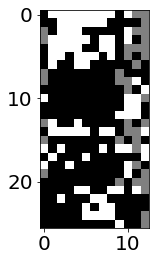

,Consumer Goods,Coal Operations,Construction Materials,Iron and Steel Producers,Metals and Mining
Environment,1.333333,2.333333,3.000000,2.666667,3.000000
Social Capital,1.571429,1.285714,1.000000,1.000000,1.285714
Human Capital,1.666667,2.333333,1.666667,1.666667,2.333333
Business Model and Innovation,2.000000,1.400000,1.400000,1.400000,1.000000
Leadership and Governance,1.000000,1.000000,1.400000,1.000000,1.400000


In [0]:
# First we will create the materiality map for the different sectors of interest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
matrix = [
[1,3,3,3,3,3,3,3,3,1,3,2,2], 
[1,1,3,3,3,3,3,3,1,1,1,1,2],
[2,1,3,3,3,1,1,1,1,1,3,2,2], 
[2,3,3,3,3,3,1,3,3,1,3,1,2], 
[1,3,3,3,3,1,1,3,3,1,2,2,2], 
[1,3,3,1,3,3,3,1,3,1,2,1,2],
[1,3,1,1,3,3,1,1,1,1,1,2,1],
[2,1,1,1,1,1,1,1,1,2,1,1,1],
[2,1,1,1,1,1,1,1,1,2,2,3,1], 
[1,1,1,1,1,1,1,1,1,1,2,1,3], 
[3,1,1,1,1,1,1,1,1,1,3,3,2],
[1,1,1,1,1,1,1,1,1,1,3,3,1],
[1,1,1,1,1,1,1,1,1,3,3,3,1],
[2,3,1,1,3,1,1,1,1,1,2,1,2], 
[1,3,3,3,3,3,1,3,3,1,2,2,3], 
[2,1,1,1,1,1,1,1,1,2,1,2,1],
[3,1,3,1,1,1,1,3,1,3,3,2,3], 
[1,3,1,1,1,3,1,1,1,1,1,1,3],
[3,1,1,3,1,1,1,1,1,1,3,2,1],
[2,1,1,1,1,1,1,1,1,1,3,1,2], 
[1,1,1,1,1,1,1,1,1,2,1,2,2],
[1,1,1,1,3,3,1,1,3,3,1,3,2],
[1,1,3,1,1,1,3,3,1,1,1,1,1], 
[1,1,1,1,1,3,1,3,3,1,1,1,1],
[1,1,1,1,1,3,3,3,3,1,1,1,2],
[1,1,1,1,1,1,1,1,1,3,1,1,2]]

sectors = ["Consumer_Goods", "Coal_Operations", "Construction_Materials", "Iron_and_Steel_Producers", "Metals_and_Mining", "Oil_and_Gas_Expl", "Oil_and_Gas_Mid", "Oil_and_Gas_Ref", "Oil_and_Gas_Serv", "Financials", "Food_and_Beverage", "Health_Care", "Infrastructure"]

sectors = [sector.replace('_', ' ') for sector in sectors]

topic = ["GHG Emissions", "Air Quality", "Energy Management",
"Water & Wastewater Management", "Waste & Hazardous Materials Management",
"Ecological Impacts", "Human Rights & Community Relations", "Customer Privacy", "Data Security", "Access & Affordability", "Product Quality & Safety", "Customer Welfare", "Selling Practices & Product Labeling", "Labor Practices", "Employee Health & Safety", "Employee Engagement, Diversity & Inclusion", "Product Design & Lifecycle Management", "Business Model Resllience", "Supply Chain Management", "Materials Sourcing & Efficiency", "Physical Impacts of Climate Change", "Business Ethics", "Competitive Behavior", "Management of the Legal & Regulatory Environment", "Critical Incident Risk Management", "Systemic Risk Management"]

sector_dict = {'Environment':["GHG Emissions", "Air Quality", "Energy Management",
"Water & Wastewater Management", "Waste & Hazardous Materials Management",
"Ecological Impacts"], 'Social Capital':["Human Rights & Community Relations", "Customer Privacy", "Data Security", "Access & Affordability", "Product Quality & Safety", "Customer Welfare", "Selling Practices & Product Labeling"], 'Human Capital':[ "Labor Practices", "Employee Health & Safety", "Employee Engagement, Diversity & Inclusion"], 'Business Model and Innovation':["Product Design & Lifecycle Management","Business Model Resllience", "Supply Chain Management", "Materials Sourcing & Efficiency", "Physical Impacts of Climate Change"], "Leadership and Governance":["Business Ethics", "Competitive Behavior", "Management of the Legal & Regulatory Environment", "Critical Incident Risk Management", "Systemic Risk Management"]}

plt.imshow(matrix, cmap='gray', interpolation='nearest')

materiality_mat = pd.DataFrame(matrix, columns = sectors, index = topic)
# Reduce the materiality matrix:

matric = []
for sector in sector_dict.keys():
    df_temp = materiality_mat.loc[sector_dict[sector]]
    matric.append(df_temp.mean(axis=0))
    
reduced_materiality_mat = pd.DataFrame(np.array(matric).T.tolist(), columns=sector_dict.keys(), index=df_temp.mean(axis=0).keys())

reduced_materiality_mat.iloc[:5,:].T

In [0]:
mat_sectors = ["Consumer Goods", "Financials", "Food & Beverage", "Health Care", "Infrastructure"]
df_sectors = final_df[final_df["Sector"].isin(mat_sectors)]
# Group by the sectors
df_sectors = df_sectors.groupby("Sector").mean().reset_index().rename({"Sector":"Area"},axis=1)
# # get remaining industries
final_df.replace({"Oil & Gas â€“ Services": "Oil and Gas Serv", "Oil & Gas â€“ Midstream":"Oil and Gas Mid", "Oil & Gas â€“ Exploration & Production": "Oil and Gas Expl", "Metals & Mining": "Metals and Mining", "Iron & Steel Producers": "Iron and Steel Producers"}, inplace=True)

# display(final_df)
remaining_industries = ["Oil and Gas Expl", "Coal Operations", "Construction Materials", "Oil and Gas Mid", "Oil and Gas Ref", "Oil and Gas Serv", "Iron and Steel Producers", "Metals and Mining"]
df_industries = final_df[final_df["Industry"].isin(remaining_industries)].groupby("Industry").mean().reset_index().rename({"Industry":"Area"}, axis=1)
df_data_driven = pd.concat([df_sectors, df_industries], axis = 0).replace({"Food & Beverage": "Food and Beverage"})
df_data_driven.set_index('Area', inplace=True)
# display(df_data_driven)


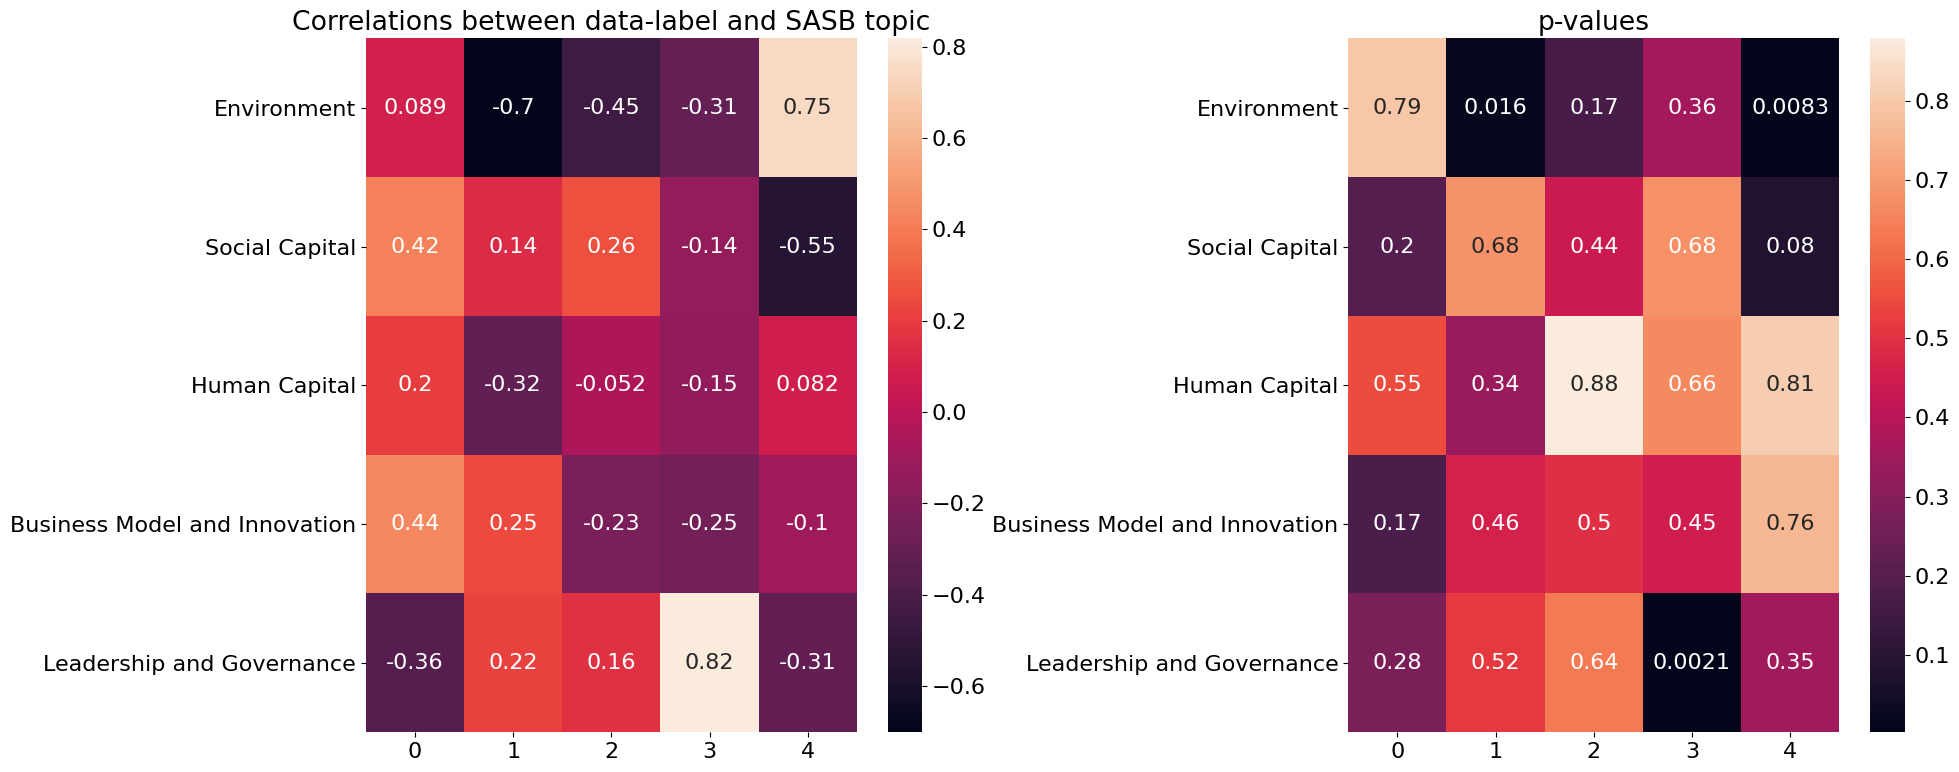

In [0]:
df_final = pd.concat([df_data_driven, reduced_materiality_mat], axis = 1).dropna().drop(["Publication_Year","count", "count_num_words"], axis=1)

import seaborn as sns
import matplotlib
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)
font = {'size'   : 16}
matplotlib.rc('font', **font)

# Correlating
fig, ax = plt.subplots(1, 2, figsize = (20,8))
sns.heatmap(df_final.corr().iloc[:5, 5:].T, annot=True, ax = ax[0])

from scipy.stats import pearsonr
# Calculate p-values
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

pvalues_matrix = calculate_pvalues(df_final).apply(pd.to_numeric, errors='coerce')

sns.heatmap(pvalues_matrix.iloc[5:,:5], annot=True, ax = ax[1])
# Low values mean the model is more confident
ax[0].set_title("Correlations between data-label and SASB topic")
ax[1].set_title("p-values")
fig.tight_layout()


# ------ Stage 3: Sectoral Analysis ------
First identify the topic in the model that is correlated with the environment dimension and store it in number, unfortunately this changes every time

In [0]:
number = "4"

Requirement already satisfied: adjustText in /local_disk0/.ephemeral_nfs/envs/pythonEnv-64376ae5-b0fe-4d7b-8c04-8bd2c668a650/lib/python3.8/site-packages (0.7.3)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from adjustText) (1.20.1)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.8/site-packages (from adjustText) (3.4.2)
Requirement already satisfied: python-dateutil>=2.7 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->adjustText) (2.8.1)
Requirement already satisfied: pillow>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->adjustText) (8.2.0)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->adjustText) (0.10.0)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->adjustText) (1.3.1)
Requirement already satisfied: pyparsing>=2.2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->adjustText) (2.4.7)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from cycler>=0.10->matplotlib->adjustText) (1.15.0)
 WARNING: You are using pip version 21.0.1; however, version 22.2.2 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-64376ae5-b0fe-4d7b-8c04-8bd2c668a650/bin/python -m pip install --upgrade pip' command. 
<command-645418633931987>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 processed_df['Percent_Change'] = (processed_df["2018_GHG_Scope_1__gCO2/RPK_"] - processed_df["2019_GHG_Scope_1__gCO2/RPK_"])/processed_df["2018_GHG_Scope_1__gCO2/RPK_"]*100
/databricks/python/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
 warnings.warn("kurtosistest only valid for n>=20 ... continuing "
 OLS Regression Results 
==============================================================================
Dep. Variable: y R-squared: 0.033
Model: OLS Adj. R-squared: -0.064
Method: Least Squares F-statistic: 0.3416
Date: Wed, 31 Aug 2022 Prob (F-statistic): 0.572
Time: 12:05:55 Log-Likelihood: -47.862
No. Observations: 12 AIC: 99.72
Df Residuals: 10 BIC: 100.7
Df Model: 1 
Covariance Type: nonrobust 
==============================================================================
 coef std err t P>|t| [0.025 0.975]
------------------------------------------------------------------------------
const 87.3746 16.381 5.334 0.000 50.875 123.874
x1 37.1897 63.627 0.584 0.572 -104.581 178.960
==============================================================================
Omnibus: 0.559 Durbin-Watson: 1.346
Prob(Omnibus): 0.756 Jarque-Bera (JB): 0.583
Skew: -0.366 Prob(JB): 0.747
Kurtosis: 2.206 Cond. No. 16.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
/databricks/python/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
 warnings.warn("kurtosistest only valid for n>=20 ... continuing "
 OLS Regression Results 
==============================================================================
Dep. Variable: y R-squared: 0.015
Model: OLS Adj. R-squared: -0.084
Method: Least Squares F-statistic: 0.1507
Date: Wed, 31 Aug 2022 Prob (F-statistic): 0.706
Time: 12:05:55 Log-Likelihood: -36.563
No. Observations: 12 AIC: 77.13
Df Residuals: 10 BIC: 78.10
Df Model: 1 
Covariance Type: nonrobust 
==============================================================================
 coef std err t P>|t| 

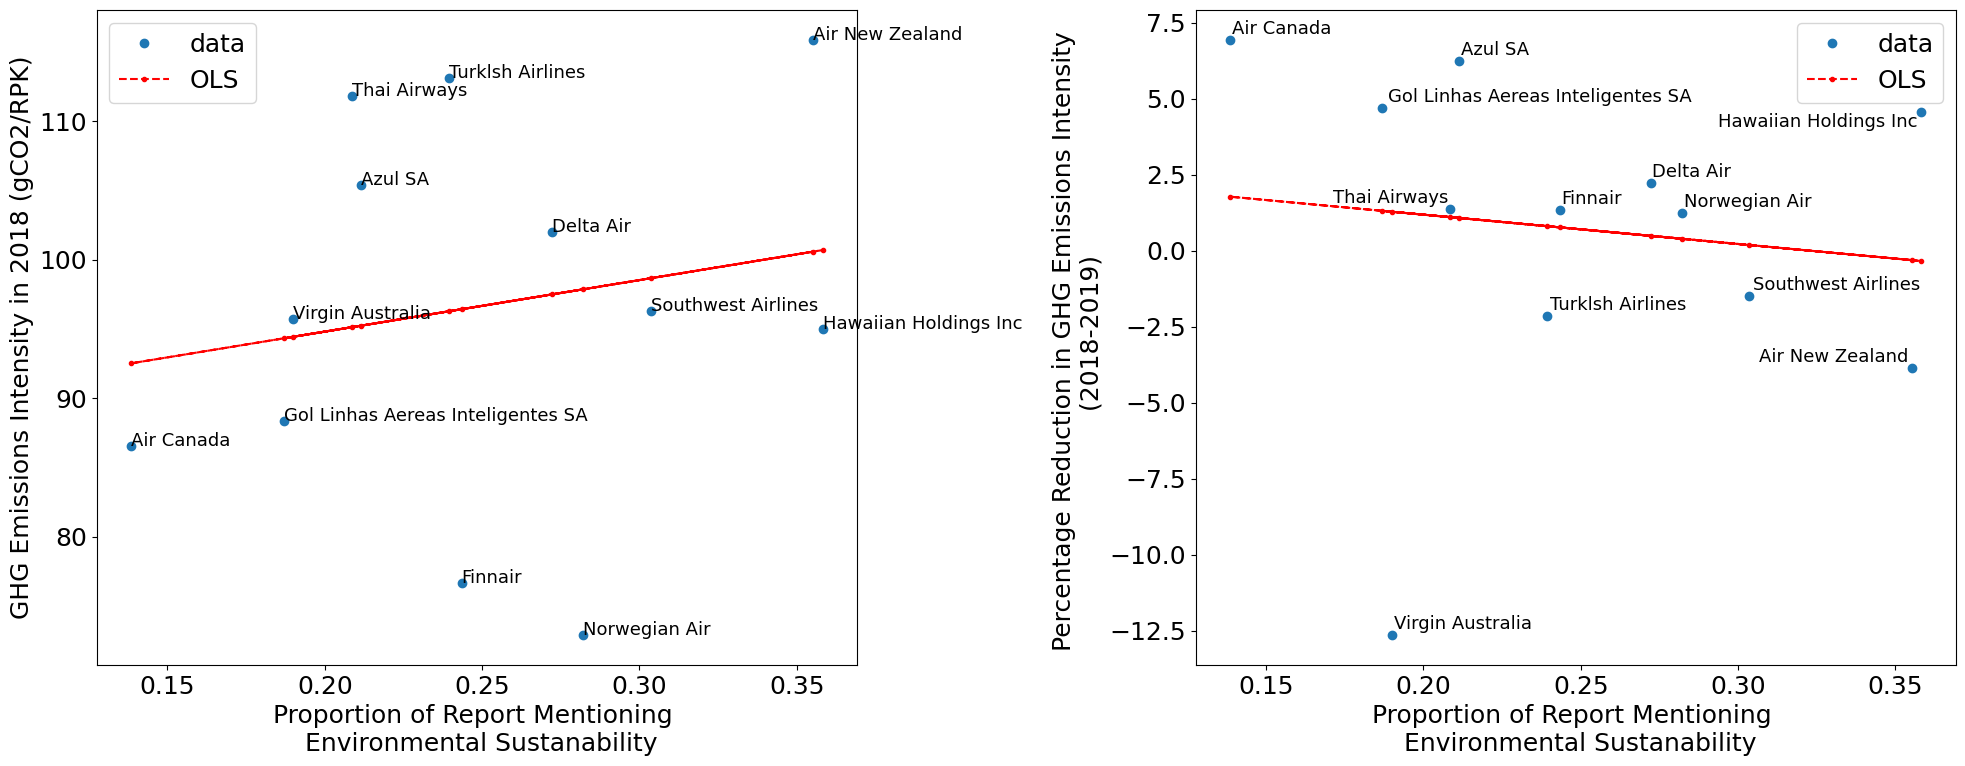

In [0]:
!pip install adjustText
fig, ax = plt.subplots(1, 2, figsize =(20,8))
font = {'size'   : 18}
matplotlib.rc('font', **font)
axs = ax.ravel()
import seaborn as sns
import pandas as pd 
df_airline_rating = sqlContext.sql("SELECT * FROM airline_rating")
df_airline_rating = df_airline_rating.toPandas()
df.Publication_Year = df.Publication_Year.astype(int)
# df.dtypes
# print(df_airline_rating.dtypes)
df_new = df_airline_rating.merge(final_df, how="left", on = ["Company_name", "Industry", "Sector", "Country", "Publication_Year"])
airlines_not_in = ["Japan Airlines", "Lufthansa", "Iberia", "Singapore Air"]
processed_df = df_new[~df_new["Company_name"].isin(airlines_not_in)]
processed_df['Percent_Change'] = (processed_df["2018_GHG_Scope_1__gCO2/RPK_"] - processed_df["2019_GHG_Scope_1__gCO2/RPK_"])/processed_df["2018_GHG_Scope_1__gCO2/RPK_"]*100
processed_df.reset_index(inplace=True)
processed_df.columns = processed_df.columns.astype(str)
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from adjustText import adjust_text



x = np.array(processed_df[[number]])
X = sm.add_constant(x)
y = np.array(processed_df[["2018_GHG_Scope_1__gCO2/RPK_"]])
res = sm.OLS(y, X).fit()
print(res.summary())
prstd, iv_l, iv_u = wls_prediction_std(res)
axs[0].plot(x, y, 'o', label="data")
axs[0].plot(x, res.fittedvalues, 'r--.', label="OLS")
# ax.plot(x, iv_u, 'r--')
# ax.plot(x, iv_l, 'r--')
axs[0].legend(loc='best')
axs[0].set_xlabel("Proportion of Report Mentioning \n Environmental Sustanability")
axs[0].set_ylabel("GHG Emissions Intensity in 2018 (gCO2/RPK)")
texts2 = [axs[0].text(processed_df[number][i], processed_df["2018_GHG_Scope_1__gCO2/RPK_"][i], processed_df.Company_name[i], fontsize=13) for i in range(len(processed_df))]
# adjust_text(texts2)

x = np.array(processed_df[[number]])
X = sm.add_constant(x)
y = np.array(processed_df[["Percent_Change"]])
res = sm.OLS(y, X).fit()
print(res.summary())
prstd, iv_l, iv_u = wls_prediction_std(res)
axs[1].plot(x, y, 'o', label="data")
axs[1].plot(x, res.fittedvalues, 'r--.', label="OLS")
# ax.plot(x, iv_u, 'r--')
# ax.plot(x, iv_l, 'r--')
axs[1].legend(loc='best')
axs[1].set_xlabel("Proportion of Report Mentioning \n Environmental Sustanability")
axs[1].set_ylabel("Percentage Reduction in GHG Emissions Intensity \n (2018-2019)")
texts = [axs[1].text(processed_df[number][i], processed_df["Percent_Change"][i], processed_df.Company_name[i], fontsize=13) for i in range(len(processed_df))]
adjust_text(texts)



fig.tight_layout()


## Oil and Gas

In [0]:
df_oilandgas = sqlContext.sql("SELECT * FROM oilandgasratingsmall_1_csv")
df_oilandgas = df_oilandgas.toPandas()
df_oilandgas.head()
df_oilandgas['Quantile_rank_progress'] = pd.qcut(df_oilandgas['Percent_Change'], 4, labels = False)
df_oilandgas['Quantile_rank_state'] = pd.qcut(df_oilandgas['2019'], 4, labels = False)
df_oilandgas = df_oilandgas[~df_oilandgas["Company_name"].isin(["Range Resources Corp", "MOL Hungarian Oil & Gas PLC"])]

processed_df = final_df.merge(df_oilandgas, how = 'inner', left_on= "Company_name", right_on="Company_name")

processed_df.head()

Out[43]:

,Company_name,Industry_x,Sector_x,Country_x,Publication_Year_x,count,count_num_words,0,1,2,3,4,_c0,Industry_y,Sector_y,Country_y,Type_of_Document,Publication_Year_y,url,2017,2018,2019,Percent_Change,Quantile_rank_progress,Quantile_rank_state
0,ARC Resources Ltd.,Oil and Gas Expl,Extractives & Minerals Processing,Canada,2020,184.560000,26.046667,0.099572,0.086663,0.262445,0.289081,0.262239,179,Oil & Gas Exploration & Production,Extractives & Minerals Processing,Canada,Corporate Responsibility Reports,2020,https://www.arcresources.com/assets/pdf/ARC-Re...,0.0260,0.02000,0.01240,0.380000,3,0
1,Antero Resources Corp,Oil and Gas Expl,Extractives & Minerals Processing,United States,2020,169.695122,24.475610,0.085447,0.032264,0.255598,0.173585,0.453107,163,Oil & Gas Exploration & Production,Extractives & Minerals Processing,United States,Corporate Responsibility Reports,2020,https://d1io3yog0oux5.cloudfront.net/_5b002c80...,0.0034,0.00267,0.00226,0.153558,2,0
2,California Resources Corp,Oil and Gas Expl,Extractives & Minerals Processing,United States,2020,160.163265,23.040816,0.100465,0.057441,0.321586,0.151425,0.369083,451,Oil & Gas Exploration & Production,Extractives & Minerals Processing,United States,Corporate Responsibility Reports,2020,https://crc.com/images/documents/sustainabilit...,0.0259,0.02650,0.02200,0.169811,2,1
3,Callon Petroleum Co,Oil and Gas Expl,Extractives & Minerals Processing,United States,2020,264.062500,36.645833,0.055187,0.089908,0.345646,0.289868,0.219391,454,Oil & Gas Exploration & Production,Extractives & Minerals Processing,United States,Corporate Responsibility Reports,2020,https://d1io3yog0oux5.cloudfront.net/callon/fi...,0.0270,0.02700,0.02700,0.000000,0,1
4,Crescent Point Energy Corp,Oil and Gas Expl,Extractives & Minerals Processing,Canada,2020,190.913462,27.644231,0.127123,0.129452,0.253717,0.239201,0.250507,694,Oil & Gas Exploration & Production,Extractives & Minerals Processing,Canada,Corporate Responsibility Reports,2020,https://www.crescentpointenergy.com/sites/defa...,0.0590,0.05400,0.05100,0.055556,2,3


/databricks/python/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
 warnings.warn("kurtosistest only valid for n>=20 ... continuing "
 OLS Regression Results 
==============================================================================
Dep. Variable: y R-squared: 0.096
Model: OLS Adj. R-squared: 0.026
Method: Least Squares F-statistic: 1.373
Date: Wed, 31 Aug 2022 Prob (F-statistic): 0.262
Time: 12:05:56 Log-Likelihood: 39.625
No. Observations: 15 AIC: -75.25
Df Residuals: 13 BIC: -73.83
Df Model: 1 
Covariance Type: nonrobust 
==============================================================================
 coef std err t P>|t| [0.025 0.975]
------------------------------------------------------------------------------
const 0.0359 0.011 3.371 0.005 0.013 0.059
x1 -0.0390 0.033 -1.172 0.262 -0.111 0.033
==============================================================================
Omnibus: 0.213 Durbin-Watson: 2.398
Prob(Omnibus): 0.899 Jarque-Bera (JB): 0.239
Skew: 0.218 Prob(JB): 0.887
Kurtosis: 2.561 Cond. No. 7.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
/databricks/python/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
 warnings.warn("kurtosistest only valid for n>=20 ... continuing "
 OLS Regression Results 
==============================================================================
Dep. Variable: y R-squared: 0.044
Model: OLS Adj. R-squared: -0.030
Method: Least Squares F-statistic: 0.5951
Date: Wed, 31 Aug 2022 Prob (F-statistic): 0.454
Time: 12:05:56 Log-Likelihood: 2.8061
No. Observations: 15 AIC: -1.612
Df Residuals: 13 BIC: -0.1961
Df Model: 1 
Covariance Type: nonrobust 
==============================================================================
 coef std err t P>|t| [0.025 0.975]
------------------------------------------------------------------------------
const 0.1914 0.124 1.544 0.147 -0.076 0.459
x1 -0.2986 0.387 -0.771 0.454 -1.135 0.538
==============================================================================
Omnibus: 13.227 Durbin-Watson: 1.917
Prob(Omnibus): 0.001 Jarque-Bera (JB): 9.432
Skew: 1.594 Prob(JB): 0.00895
Kurtosis: 5.219 Cond. No. 7.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

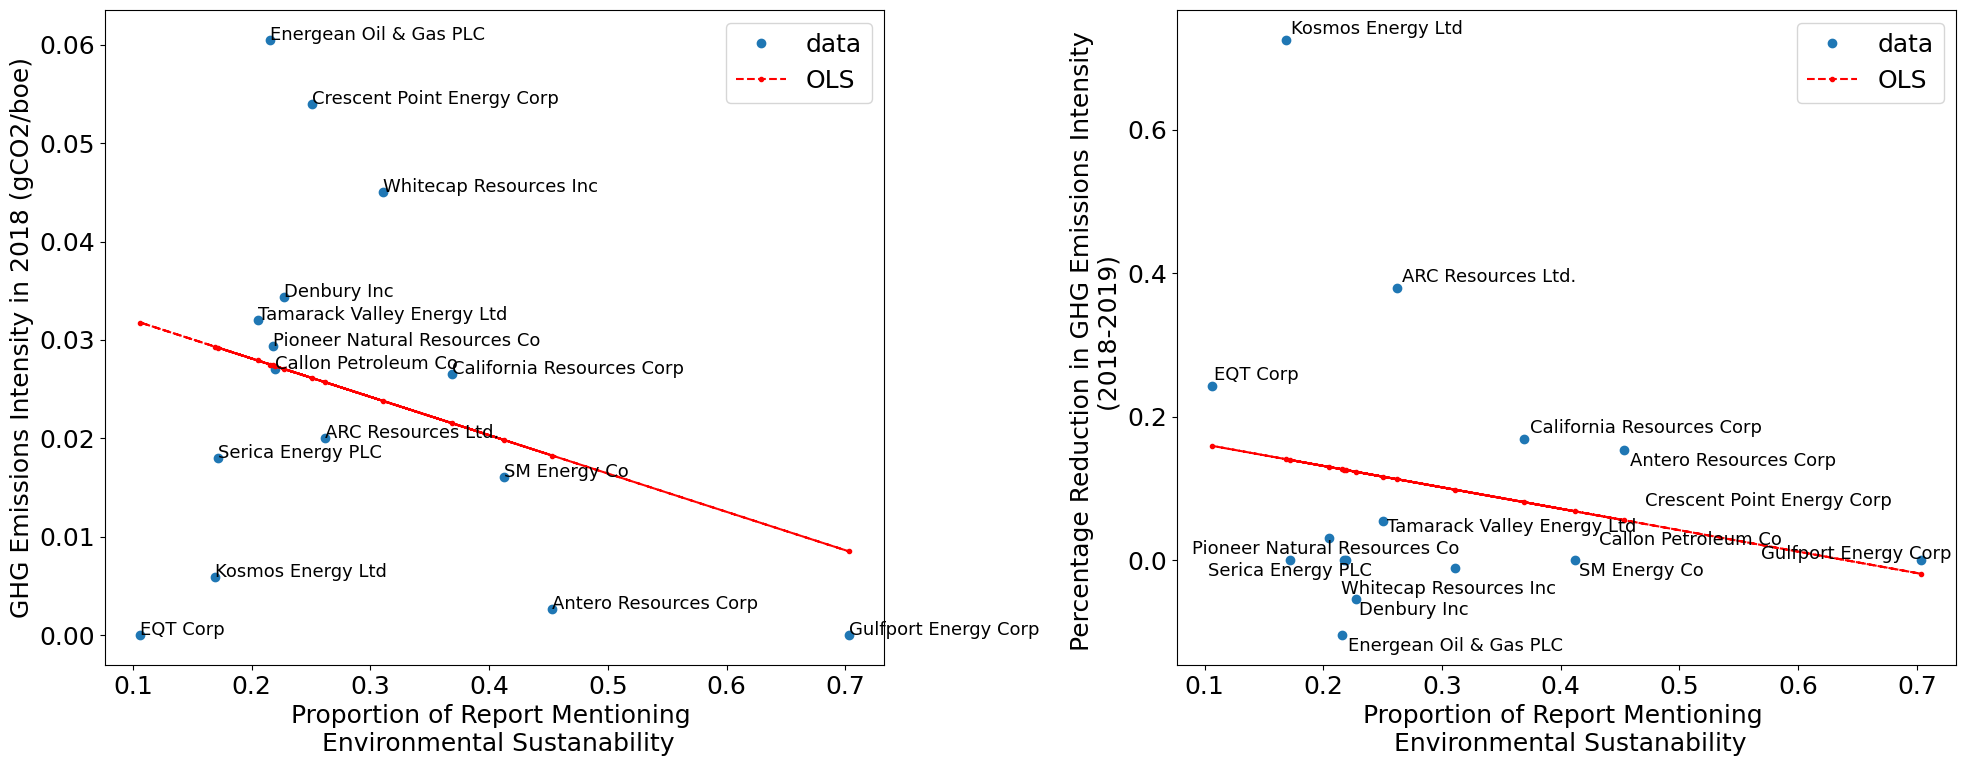

In [0]:
# Plotting
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from adjustText import adjust_text

fig, ax = plt.subplots(1, 2, figsize =(20,8))

axs = ax.ravel()

x = np.array(processed_df[[number]])
X = sm.add_constant(x)
y = np.array(processed_df[["2018"]])
res = sm.OLS(y, X).fit()
print(res.summary())
prstd, iv_l, iv_u = wls_prediction_std(res)
axs[0].plot(x, y, 'o', label="data")
axs[0].plot(x, res.fittedvalues, 'r--.', label="OLS")
# ax.plot(x, iv_u, 'r--')
# ax.plot(x, iv_l, 'r--')
axs[0].legend(loc='best')
axs[0].set_xlabel("Proportion of Report Mentioning \n Environmental Sustanability")
axs[0].set_ylabel("GHG Emissions Intensity in 2018 (gCO2/boe)")
texts2 = [axs[0].text(processed_df[number][i], processed_df["2018"][i], processed_df.Company_name[i], fontsize=13) for i in range(len(processed_df))]
# adjust_text(texts2)

x = np.array(processed_df[[number]])
X = sm.add_constant(x)
y = np.array(processed_df[["Percent_Change"]])
res = sm.OLS(y, X).fit()
print(res.summary())
prstd, iv_l, iv_u = wls_prediction_std(res)
axs[1].plot(x, y, 'o', label="data")
axs[1].plot(x, res.fittedvalues, 'r--.', label="OLS")
# ax.plot(x, iv_u, 'r--')
# ax.plot(x, iv_l, 'r--')
axs[1].legend(loc='best')
axs[1].set_xlabel("Proportion of Report Mentioning \n Environmental Sustanability")
axs[1].set_ylabel("Percentage Reduction in GHG Emissions Intensity \n (2018-2019)")
texts = [axs[1].text(processed_df[number][i], processed_df["Percent_Change"][i], processed_df.Company_name[i], fontsize=13) for i in range(len(processed_df))]
adjust_text(texts)
fig.tight_layout()

## Real Estate

/databricks/python/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
 warnings.warn("kurtosistest only valid for n>=20 ... continuing "
 OLS Regression Results 
==============================================================================
Dep. Variable: y R-squared: 0.256
Model: OLS Adj. R-squared: 0.188
Method: Least Squares F-statistic: 3.779
Date: Wed, 31 Aug 2022 Prob (F-statistic): 0.0779
Time: 12:05:59 Log-Likelihood: -42.369
No. Observations: 13 AIC: 88.74
Df Residuals: 11 BIC: 89.87
Df Model: 1 
Covariance Type: nonrobust 
==============================================================================
 coef std err t P>|t| [0.025 0.975]
------------------------------------------------------------------------------
const 4.1961 6.896 0.609 0.555 -10.981 19.373
x1 53.6492 27.599 1.944 0.078 -7.097 114.395
==============================================================================
Omnibus: 0.043 Durbin-Watson: 1.455
Prob(Omnibus): 0.979 Jarque-Bera (JB): 0.256
Skew: 0.079 Prob(JB): 0.880
Kurtosis: 2.331 Cond. No. 15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
/databricks/python/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
 warnings.warn("kurtosistest only valid for n>=20 ... continuing "
 OLS Regression Results 
==============================================================================
Dep. Variable: y R-squared: 0.003
Model: OLS Adj. R-squared: -0.088
Method: Least Squares F-statistic: 0.03120
Date: Wed, 31 Aug 2022 Prob (F-statistic): 0.863
Time: 12:06:05 Log-Likelihood: 16.995
No. Observations: 13 AIC: -29.99
Df Residuals: 11 BIC: -28.86
Df Model: 1 
Covariance Type: nonrobust 
==============================================================================
 coef std err t P>|t| [0.025 0.975]
------------------------------------------------------------------------------
const -0.0877 0.072 -1.224 0.246 -0.246 0.070
x1 0.0507 0.287 0.177 0.863 -0.581 0.682
==============================================================================
Omnibus: 9.595 Durbin-Watson: 1.284
Prob(Omnibus): 0.008 Jarque-Bera (JB): 5.206
Skew: -1.277 Prob(JB): 0.0741
Kurtosis: 4.757 Cond. No. 15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

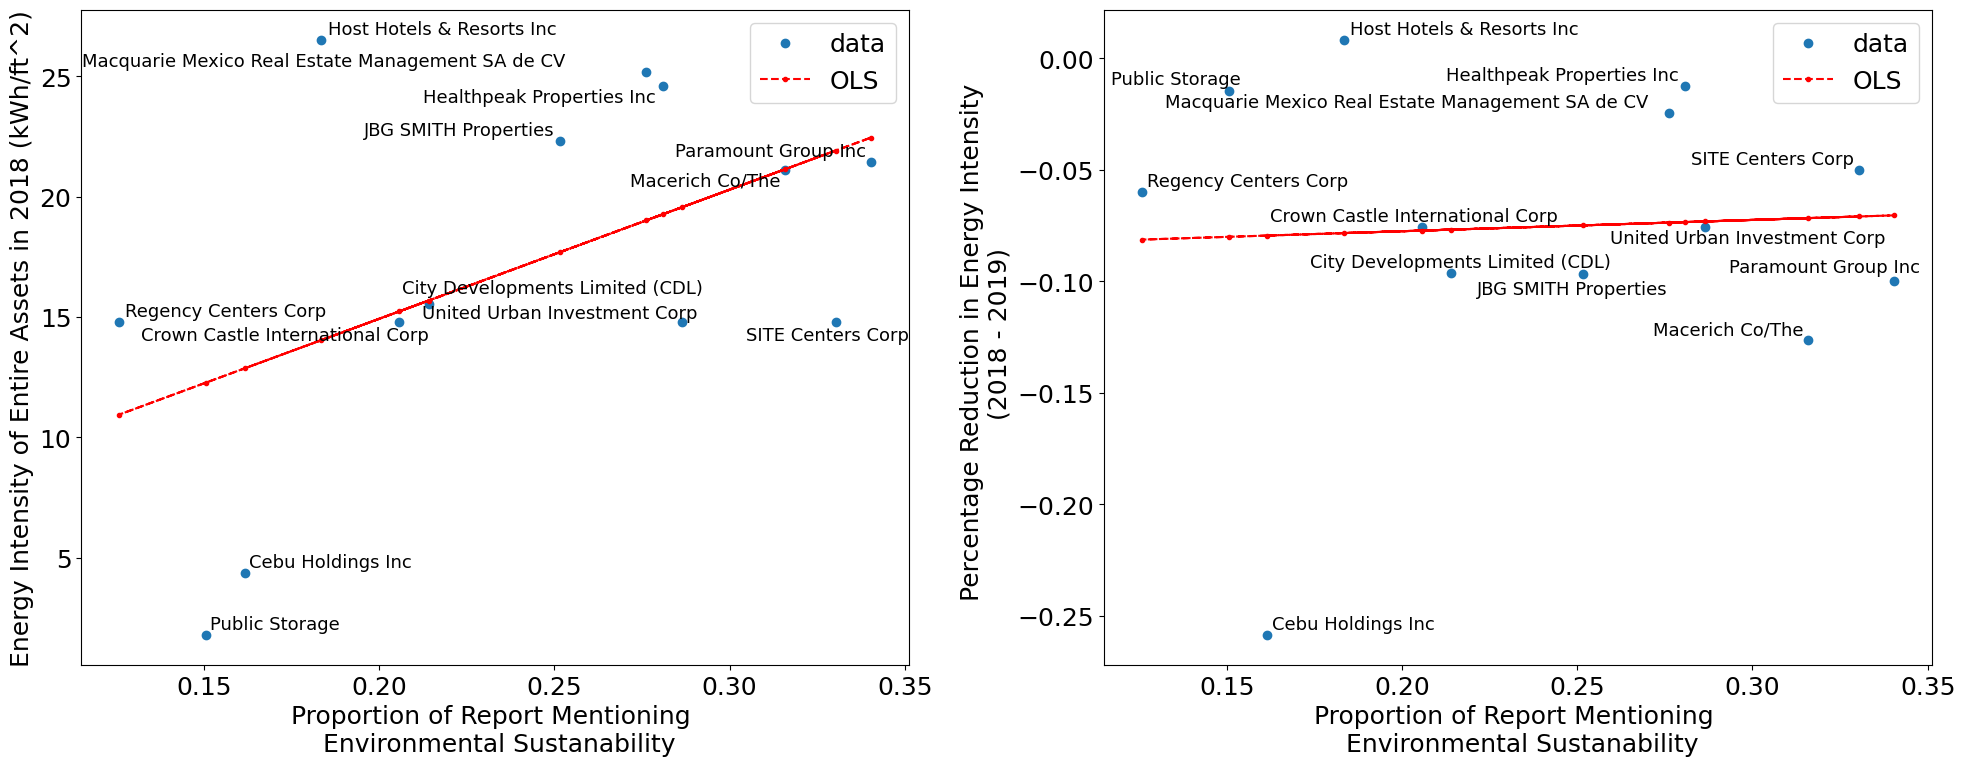

In [0]:
import seaborn as sns

df_real_estate = sqlContext.sql("SELECT * FROM realestaterating_1_csv")
df_real_estate = df_real_estate.toPandas()
df_real_estate = df_real_estate[~df_real_estate["Company_name"].isin(["Covivio"])]
processed_df = final_df.merge(df_real_estate, how = 'inner', left_on= "Company_name", right_on="Company_name")
fig, ax = plt.subplots(1, 2, figsize =(20,8))
processed_df["2018"] = processed_df["2018"].replace([0, np.nan], processed_df["2018"].mean())
processed_df["Percent_Change"] = processed_df["Percent_Change"].replace([np.nan], processed_df["Percent_Change"].mean())

axs = ax.ravel()

x = np.array(processed_df[[number]])
X = sm.add_constant(x)
y = np.array(processed_df[["2018"]])
res = sm.OLS(y, X).fit()
print(res.summary())
prstd, iv_l, iv_u = wls_prediction_std(res)
axs[0].plot(x, y, 'o', label="data")
axs[0].plot(x, res.fittedvalues, 'r--.', label="OLS")
# ax.plot(x, iv_u, 'r--')
# ax.plot(x, iv_l, 'r--')
axs[0].legend(loc='best')
axs[0].set_xlabel("Proportion of Report Mentioning \n Environmental Sustanability")
axs[0].set_ylabel("Energy Intensity of Entire Assets in 2018 (kWh/ft^2)")
texts2 = [axs[0].text(processed_df[number][i], processed_df["2018"][i], processed_df.Company_name[i], fontsize=13) for i in range(len(processed_df))]
adjust_text(texts2, ax = axs[0])

x = np.array(processed_df[[number]])
X = sm.add_constant(x)
y = np.array(processed_df[["Percent_Change"]])
res = sm.OLS(y, X).fit()
print(res.summary())
prstd, iv_l, iv_u = wls_prediction_std(res)
axs[1].plot(x, y, 'o', label="data")
axs[1].plot(x, res.fittedvalues, 'r--.', label="OLS")
# ax.plot(x, iv_u, 'r--')
# ax.plot(x, iv_l, 'r--')
axs[1].legend(loc='best')
axs[1].set_xlabel("Proportion of Report Mentioning \n Environmental Sustanability")
axs[1].set_ylabel("Percentage Reduction in Energy Intensity \n (2018 - 2019)")
texts = [axs[1].text(processed_df[number][i], processed_df["Percent_Change"][i], processed_df.Company_name[i], fontsize=13) for i in range(len(processed_df))]
adjust_text(texts, ax = axs[1])
fig.tight_layout()